In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import statsmodels.api as sm 
import statsmodels.formula.api as smf # import submodule for specifying statistical models using a formula syntax similar to R
import requests
from bs4 import BeautifulSoup
import csv

/Users/yulia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Further Exploration - Visual Analysis and Feature Engineering

## Visual EDA for MPS crime dataset

I've made an initial exploration and reorganisation of the original MPS crime data for different London Boroughs in the [*previos notebook*] (!!add link here). In this notebook intention to dig dipper and find some patterns using visualisations.

In [48]:
# Load data from a CSV file into a pandas DataFrame
df = pd.read_csv('../data/MPS/agg_filtered_boroughs_weekends.csv')

In [49]:
# Convert the 'TimePeriod' column in the DataFrame to datetime format.
df['TimePeriod'] = pd.to_datetime(df['TimePeriod'])

In [50]:
# Displays the column names
df.columns

Index(['BoroughName', 'CrimeType', 'CrimeSubtype', 'TimePeriod', 'Value',
       'WorkingDays', 'Weekends'],
      dtype='object')

Consider how many rows we are loosing if we decide to derop all the data before 2012, concidering that the amount of missing data in the NOMIS DataFtame for 2011

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271624 entries, 0 to 271623
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   BoroughName   271624 non-null  object        
 1   CrimeType     271624 non-null  object        
 2   CrimeSubtype  271624 non-null  object        
 3   TimePeriod    271624 non-null  datetime64[ns]
 4   Value         271624 non-null  int64         
 5   WorkingDays   271624 non-null  int64         
 6   Weekends      271624 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 14.5+ MB


In [7]:
# Consider dropping all the data before 2012, as we have missing information for 2011 in NOMIS data
df_2012 = df[df['TimePeriod'].dt.year >= 2012]
df_2012.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236386 entries, 35238 to 271623
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   BoroughName   236386 non-null  object        
 1   CrimeType     236386 non-null  object        
 2   CrimeSubtype  236386 non-null  object        
 3   TimePeriod    236386 non-null  datetime64[ns]
 4   Value         236386 non-null  int64         
 5   WorkingDays   236386 non-null  int64         
 6   Weekends      236386 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 14.4+ MB


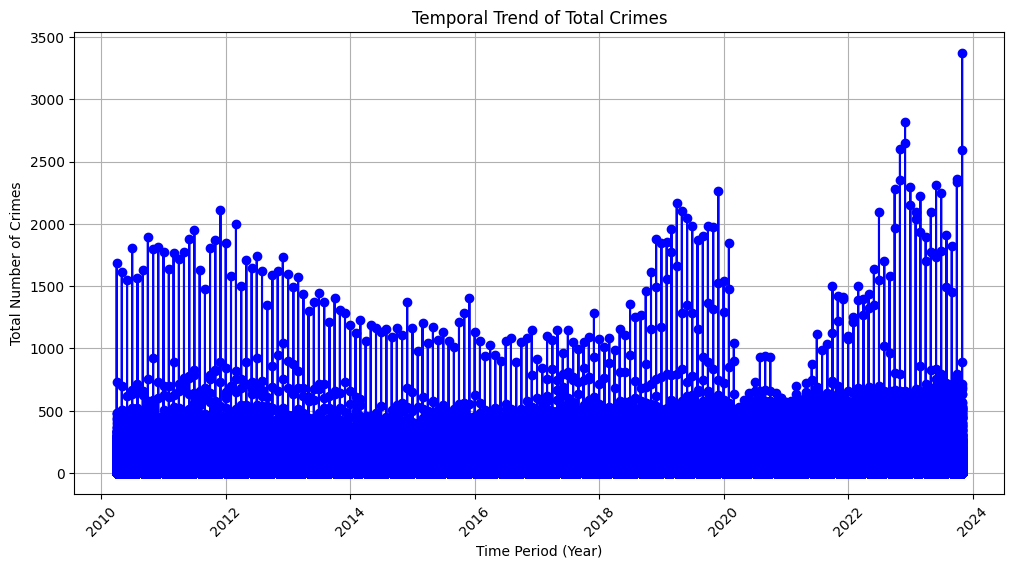

In [8]:
# Create a line plot setting the figure size
plt.figure(figsize=(12, 6))
# Plot the data using TimePeriod as x-axis and Value as y-axis
plt.plot(df['TimePeriod'], df['Value'], marker='o', linestyle='-', color='b')
# Set plot title and axis labels
plt.title('Temporal Trend of Total Crimes')
plt.xlabel('Time Period (Year)')
plt.ylabel('Total Number of Crimes')
# Display gridlines and rotate x-axis labels for better readability
plt.grid(True)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [52]:
# Set the TimePeriod column as the index
df.set_index('TimePeriod', inplace=True)
# Extract year and month information from the index and create new columns
df['Year'] = df.index.year
df['Month'] = df.index.month

In [53]:
# Prepate for further exploration and plotting, grouping the DataFrame by
# Year and Month. Aggregate the data by SUMMING up the values for each group
monthly_crime_data = df.groupby(['Year', 'Month']).sum()

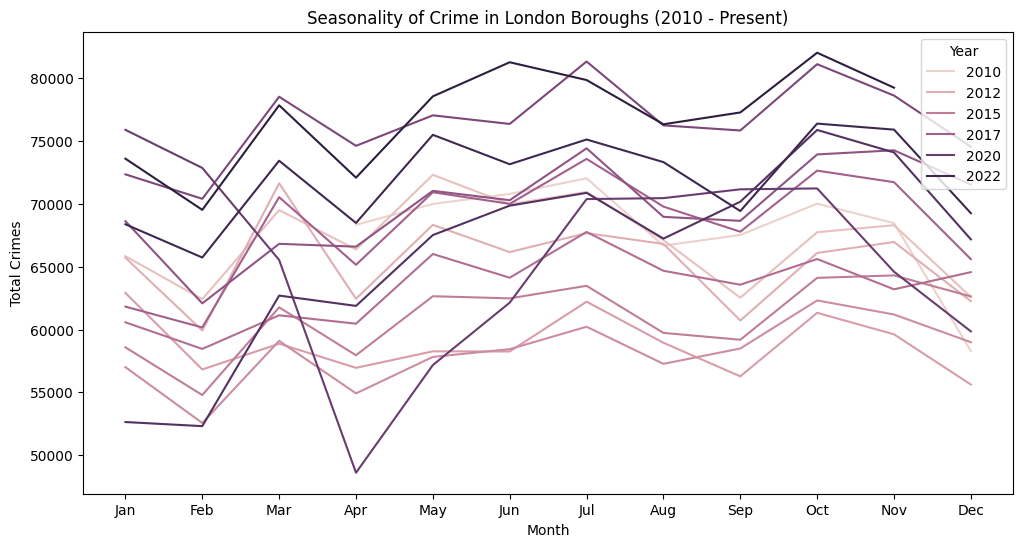

In [11]:
# Visualize the seasonality of crime in London Boroughs
# Set the figure size
plt.figure(figsize=(12, 6))
# Set the figure size
sns.lineplot(x='Month', y='Value', hue='Year', data=monthly_crime_data)
# Set plot title, x-axis label, y-axis label, x-axis ticks, and legend
plt.title('Seasonality of Crime in London Boroughs (2010 - Present)')
plt.xlabel('Month')
plt.ylabel('Total Crimes')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', loc='upper right')
# Show the plot
plt.show()

In [37]:
# Prepate for further seasonality exploration and plotting, 
# and calculate the MEAN value of crimes FOR EACH CRIME TYPE across different months
crime_seasonality = df.groupby(['CrimeType', 'Month'])['Value'].mean().reset_index()
# Rearrange data to have months as rows, crime types as columns, and mean values as values
crime_seasonality_pivot = crime_seasonality.pivot(index='Month', columns='CrimeType', values='Value')

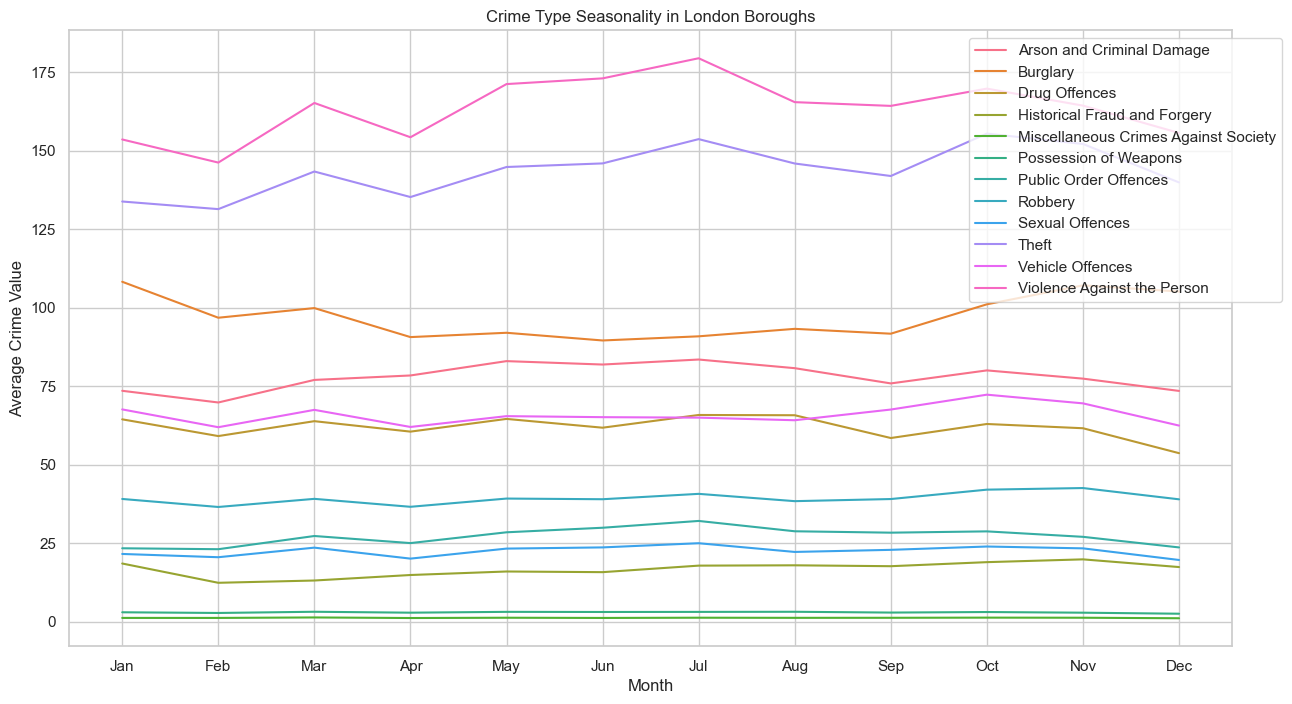

In [38]:
# Set the figure size and style
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")
# Plot a line plot using Seaborn
sns.lineplot(data=crime_seasonality_pivot, dashes=False)
# Set plot title, x-axis label, y-axis label, legend position, and x-axis ticks
plt.title('Crime Type Seasonality in London Boroughs')
plt.xlabel('Month')
plt.ylabel('Average Crime Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# Show the plot
plt.show()

In [39]:
# Prepate for further seasonality exploration and plotting, 
# and calculate the MEAN value of crimes FOR EACH CRIME SUBTYPE across different months
sub_crime_seasonality = df.groupby(['CrimeSubtype', 'Month'])['Value'].mean().reset_index()
# Rearrange data to have months as rows, crime subtypes as columns, and mean values as values
sub_crime_seasonality_pivot = sub_crime_seasonality.pivot(index='Month', columns='CrimeSubtype', values='Value')

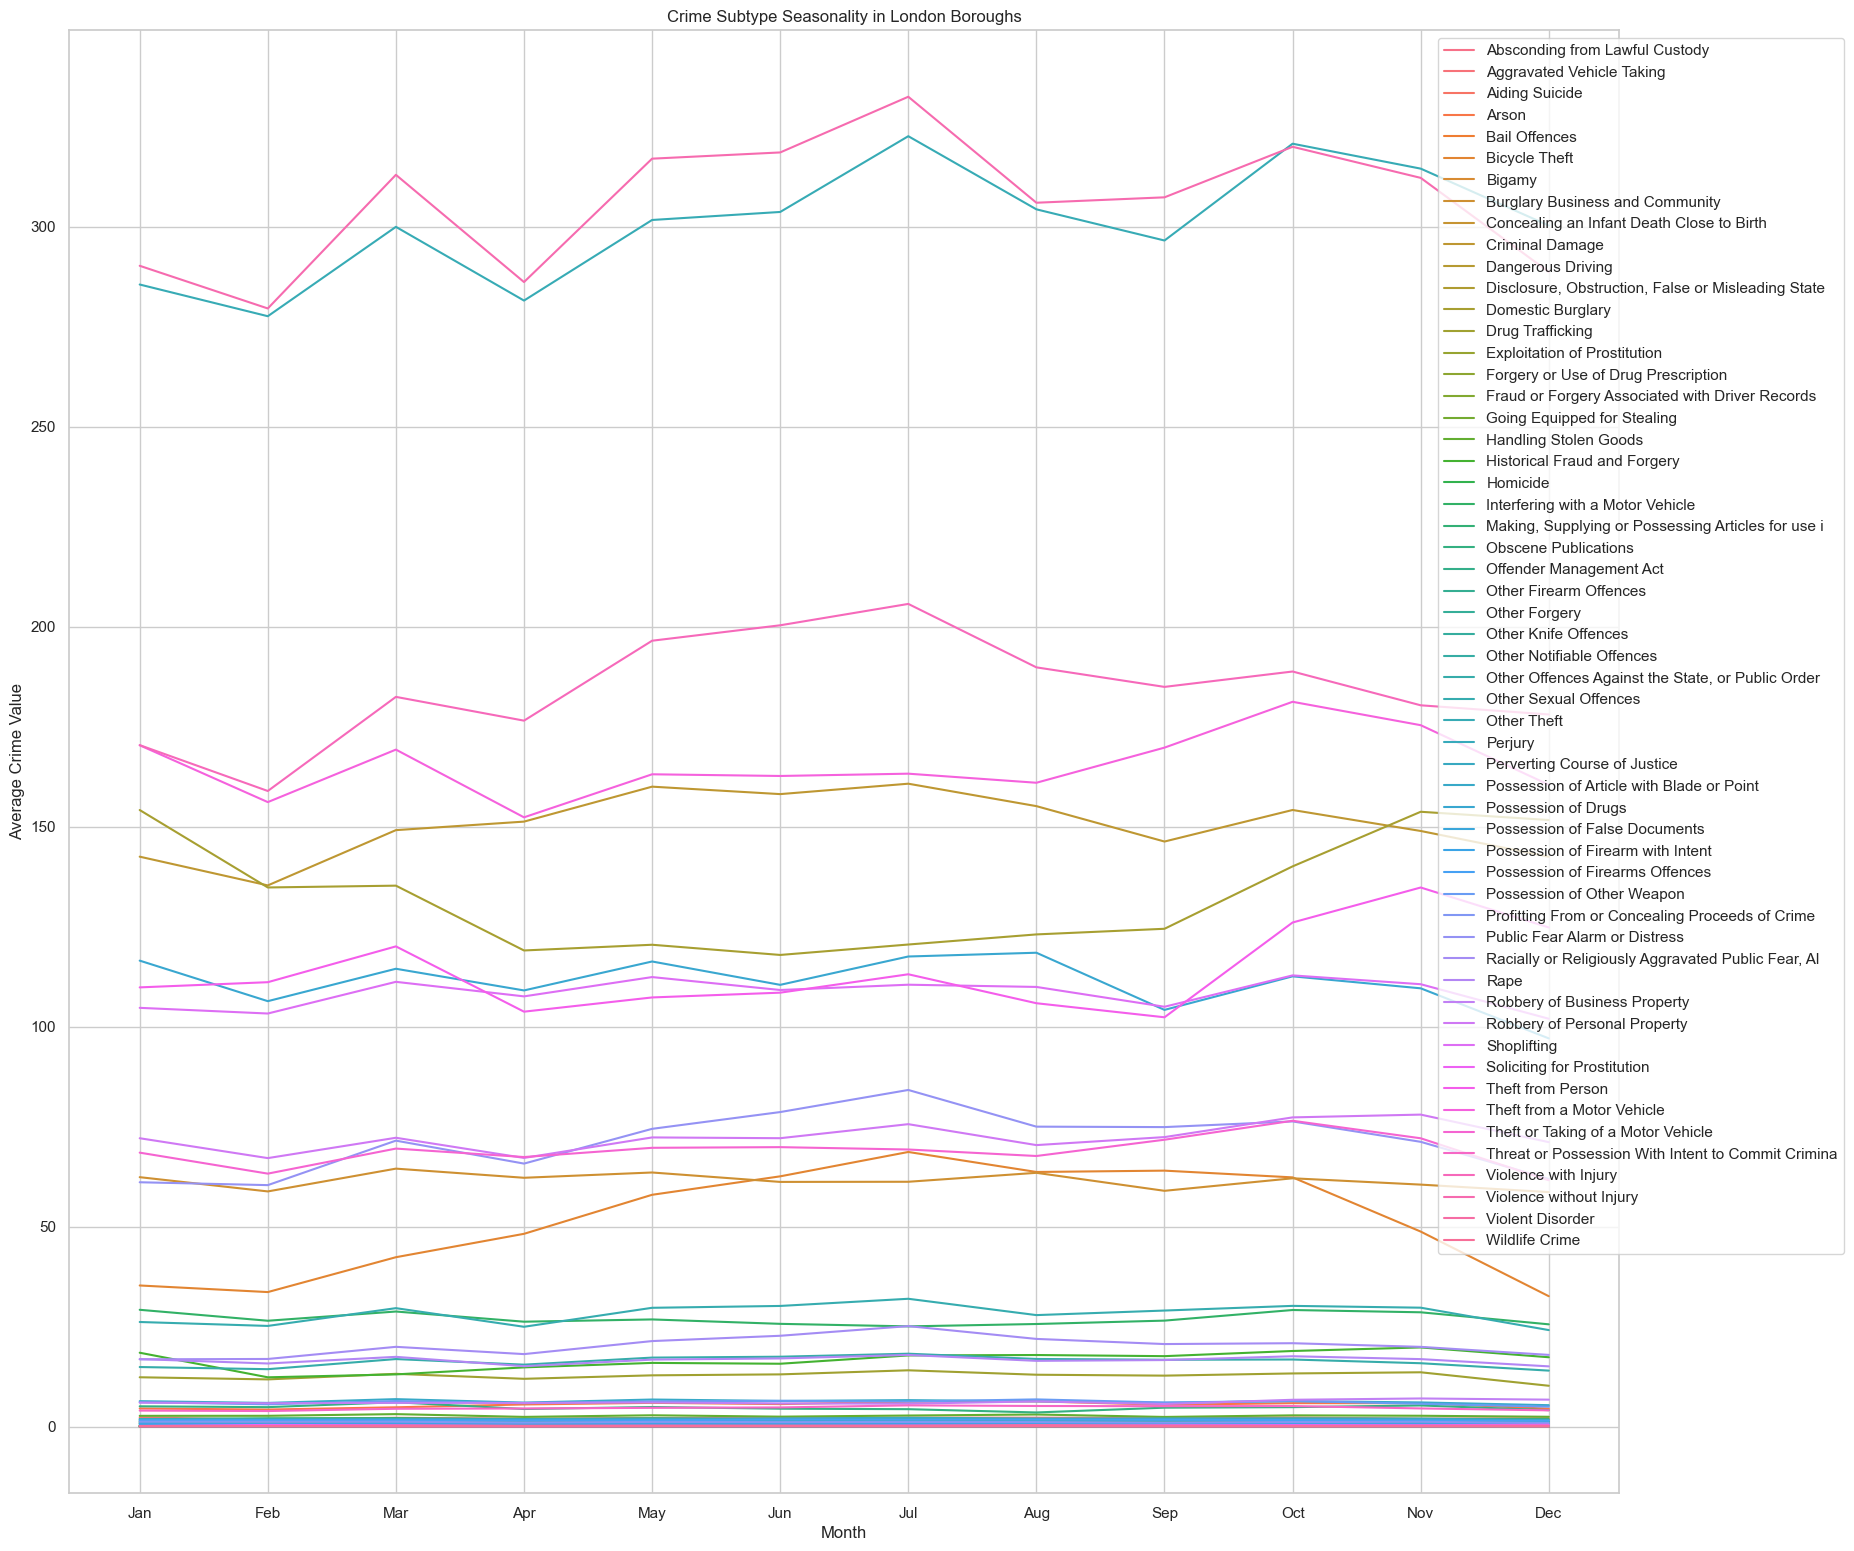

In [15]:
# Set the figure size and style
plt.figure(figsize=(20, 19))
sns.set(style="whitegrid")
# Plot a line plot using Seaborn
sns.lineplot(data=sub_crime_seasonality_pivot, dashes=False)
# Set plot title, x-axis label, y-axis label, legend position, and x-axis ticks
plt.title('Crime Subtype Seasonality in London Boroughs')
plt.xlabel('Month')
plt.ylabel('Average Crime Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# Show the plot
plt.show()

In [40]:
# Prepate data for exploration and plotting, and calculate the mean crime values for each borough
borough_crime_rates = df.groupby('BoroughName')['Value'].mean().reset_index()
# Sort from lowest to highest mean crime rates for better visual representation
borough_crime_rates_sorted = borough_crime_rates.sort_values(by='Value')

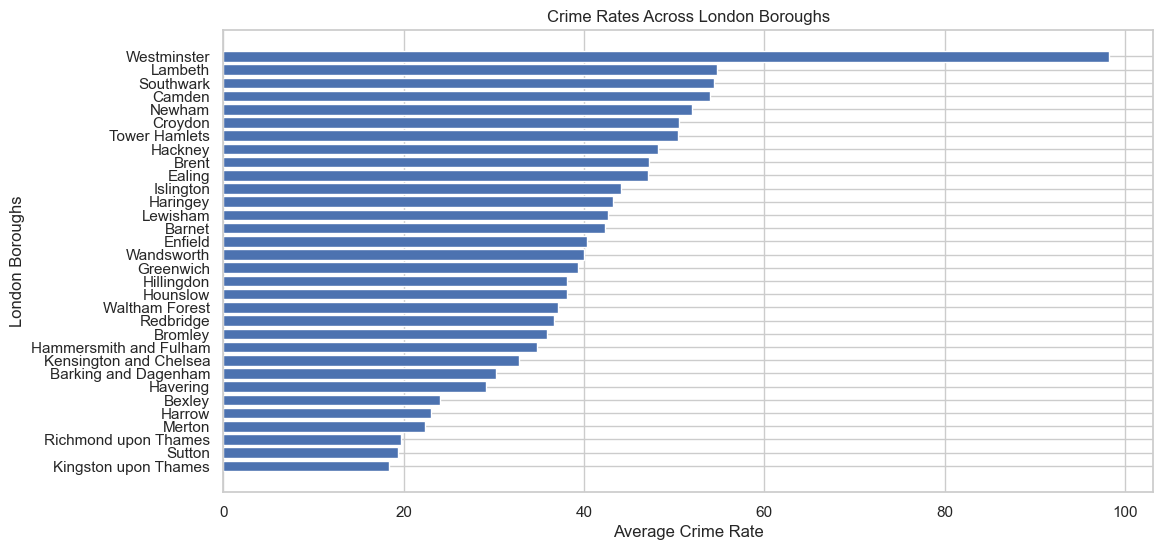

In [41]:
# Set the figure size and style
plt.figure(figsize=(12, 6))
# Plot a horizontal bar plot with borough names on the y-axis and average crime rates on the x-axis
plt.barh(borough_crime_rates_sorted['BoroughName'], borough_crime_rates_sorted['Value'])
# Set x-axis label, y-axis label, plot title 
plt.xlabel('Average Crime Rate')
plt.ylabel('London Boroughs')
plt.title('Crime Rates Across London Boroughs')
# Show the plot
plt.show()

In [18]:
# Calculate the highest and lowest crime rates
highest_crime_rate = borough_crime_rates_sorted['Value'].max()
lowest_crime_rate = borough_crime_rates_sorted['Value'].min()
# Select boroughs with the highest and lowest crime rates
highest_crime_boroughs = borough_crime_rates_sorted[borough_crime_rates_sorted['Value'] == highest_crime_rate]
lowest_crime_boroughs = borough_crime_rates_sorted[borough_crime_rates_sorted['Value'] == lowest_crime_rate]
# Display results
print(f'Boroughs with the highest crime rate:\n {highest_crime_boroughs}\
    \n\nBoroughs with the lowest crime rate:\n{lowest_crime_boroughs}')


Boroughs with the highest crime rate:
     BoroughName      Value
31  Westminster  98.231753    

Boroughs with the lowest crime rate:
             BoroughName      Value
19  Kingston upon Thames  18.364742


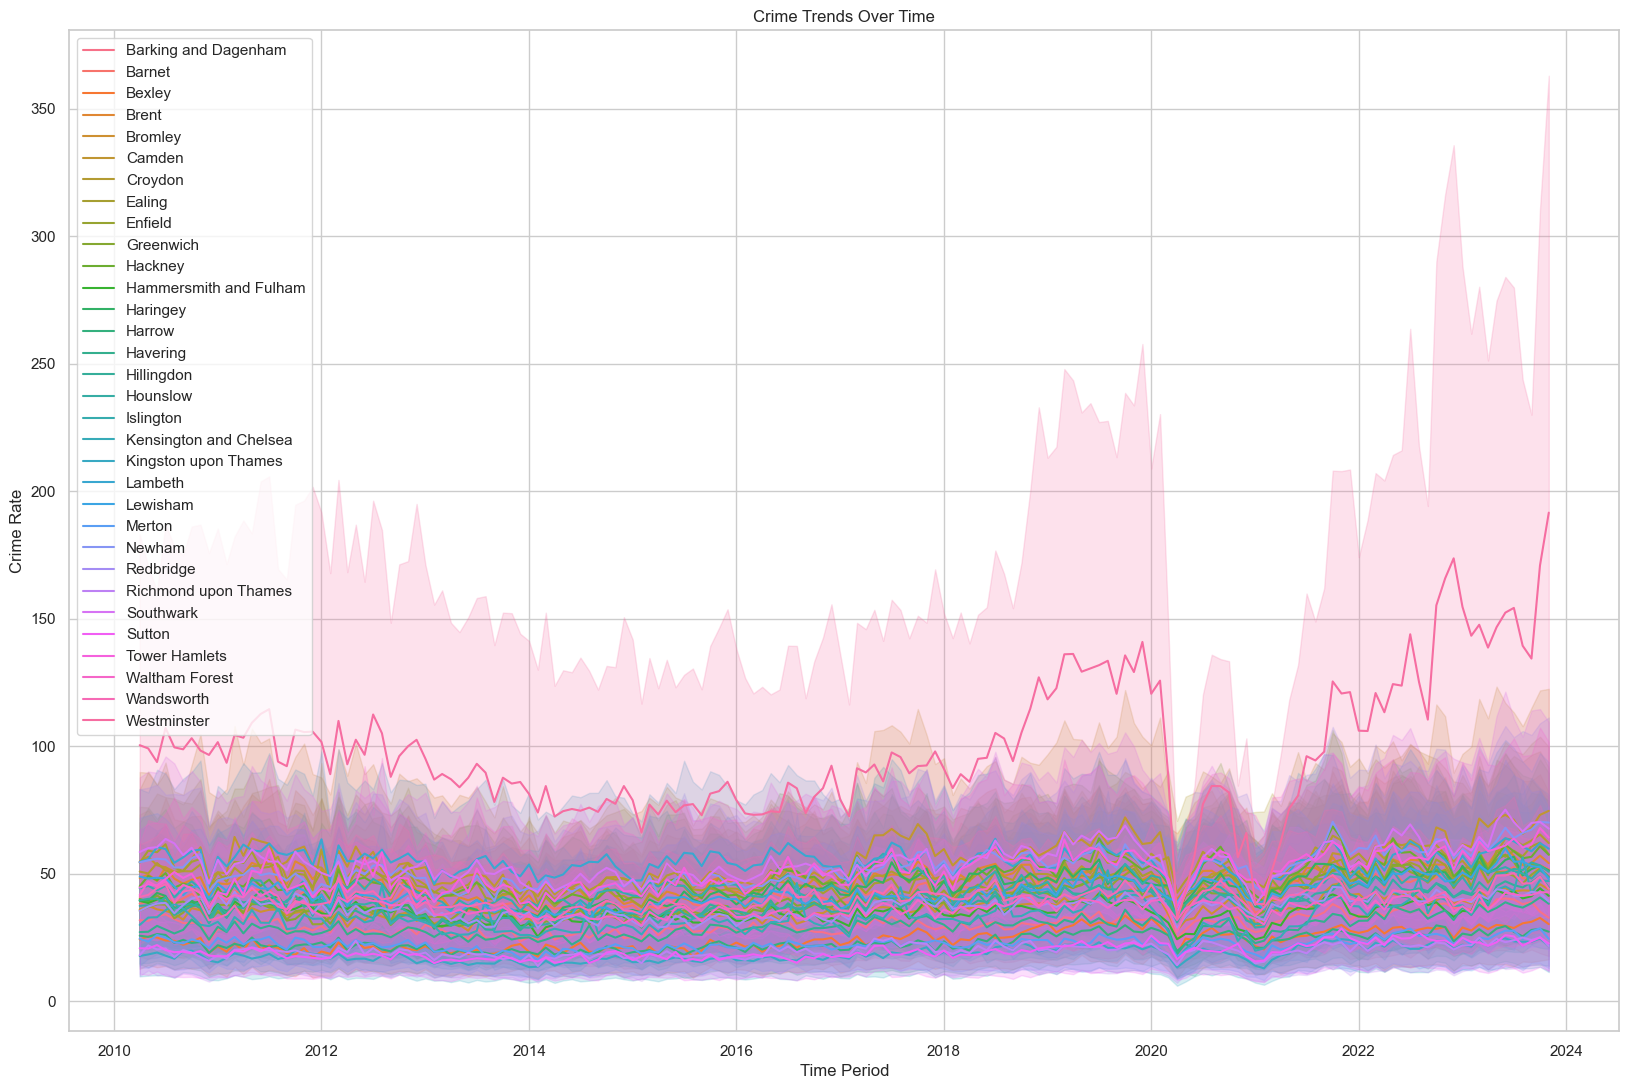

In [19]:
# Visualize the crime trends over time for different London boroughs
# Set the figure size and style
plt.figure(figsize=(20, 13))
# Create lineplot using Seaborn with TimePeriod on the x-axis, crime rates on the y-axis, and BoroughName as hue
sns.lineplot(data=df, x='TimePeriod', y='Value', hue='BoroughName')
# Set plot title, x-axis label, y-axis label, legend position
plt.title('Crime Trends Over Time')
plt.xlabel('Time Period')
plt.ylabel('Crime Rate')
plt.legend(loc='upper left')
# Show the plot
plt.show()

/Users/yulia/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


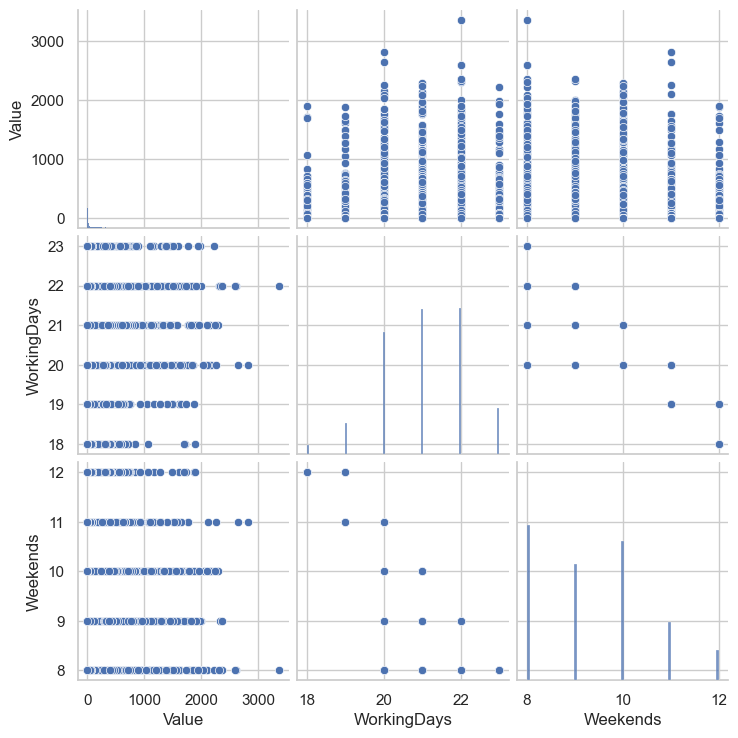

In [20]:
# Create a pair plot to visualize relationships among 'Value', 'WorkingDays', and 'Weekends' columns
sns.pairplot(df[['Value', 'WorkingDays', 'Weekends']])
plt.show()

In [21]:
# Fit a linear regression model with 'Value' as the dependent variable and 'WorkingDays' and 'Weekends' as independent variables
model = smf.ols('Value ~ WorkingDays + Weekends', data=df).fit()
# Print the summary statistics of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     28.86
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           2.92e-13
Time:                        13:13:00   Log-Likelihood:            -1.6046e+06
No. Observations:              271624   AIC:                         3.209e+06
Df Residuals:                  271621   BIC:                         3.209e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.3863      6.616     -0.512      

In [22]:
# Perform hypothesis testing on the fitted linear regression model 
# to evaluate the significance of WorkingDays and Weekends
hypothesis_test = model.t_test("WorkingDays = 0")
print("Hypothesis Test for WorkingDays:\n", hypothesis_test)

hypothesis_test = model.t_test("Weekends = 0")
print("Hypothesis Test for Weekends:\n", hypothesis_test)

Hypothesis Test for WorkingDays:
                              Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.6810      0.232      7.231      0.000       1.225       2.137
Hypothesis Test for Weekends:
                              Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.8919      0.220      4.049      0.000       0.460       1.324


In [23]:
# Perform a hypothesis test to assess the statistical significance of the difference 
# in crime rates between weekdays and weekends specifically for the 'Westminster' borough
borough_of_interest = 'Westminster'
# Filter data for Westminster borough
borough_data = df[df['BoroughName'] == borough_of_interest]
# Filter data for weekdays and weekends within the Westminster borough using boolean masking
weekdays_data = borough_data[borough_data['WorkingDays'] == 1]
weekends_data = borough_data[borough_data['Weekends'] == 1]
# Perform two-sample t-test to compare crime rates between weekdays and weekends
t_stat, p_value = stats.ttest_ind(weekdays_data['Value'], weekends_data['Value'], equal_var=False)
# Check for statistical significance based on the calculated p-value
if p_value < 0.05:
    print(f'The difference in crime rates between weekdays and weekends in {borough_of_interest} is statistically significant (p-value={p_value:.4f}).')
else:
    print(f'The difference in crime rates between weekdays and weekends in {borough_of_interest} is not statistically significant (p-value={p_value:.4f}).')

The difference in crime rates between weekdays and weekends in Westminster is not statistically significant (p-value=nan).


## Removing insignificant features

In [54]:
# Remove the columns 'WorkingDays' and 'Weekends' (as they uppear insignificant for our needs)
data = df.drop(columns=['WorkingDays', 'Weekends'])

In [57]:
trend = data
# Get yearly trend of crime values, calculating mean values for the respective groupings
trend['YearlyTrend_Value'] = trend.groupby(['BoroughName', 'CrimeType', 'CrimeSubtype', 'Month'])['Value'].transform('mean')
trend

,BoroughName,CrimeType,CrimeSubtype,Value,Year,Month,YearlyTrend_Value
TimePeriod,,,,,,,
2010-04-01,Barking and Dagenham,Arson and Criminal Damage,Arson,6,2010,4,5.785714
2010-04-01,Barking and Dagenham,Arson and Criminal Damage,Criminal Damage,208,2010,4,130.642857
2010-04-01,Barking and Dagenham,Burglary,Burglary Business and Community,49,2010,4,37.500000
2010-04-01,Barking and Dagenham,Burglary,Domestic Burglary,118,2010,4,93.500000
2010-04-01,Barking and Dagenham,Drug Offences,Drug Trafficking,9,2010,4,8.928571
...,...,...,...,...,...,...,...
2023-11-01,Westminster,Vehicle Offences,Theft from a Motor Vehicle,297,2023,11,242.214286
2023-11-01,Westminster,Vehicle Offences,Theft or Taking of a Motor Vehicle,39,2023,11,58.571429
2023-11-01,Westminster,Violence Against the Person,Homicide,0,2023,11,0.214286


In [58]:
data.reset_index(inplace=True)

In [59]:
# Save the DataFrame as a CSV file without including the index
data.to_csv('../data/MPS_agg_features/london_borough_crime.csv', index=False)

## Feature Engineering: Explore and transform NOMIS data

In [342]:
# Loading the NOMIS data from a TSV file into a pandas DataFrame
nomis = pd.read_csv('../data/MPS/nomis_data.tsv', sep='\t')
nomis = nomis.drop('Confidence', axis=1) # remove the 'Confidence' column
nomis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787472 entries, 0 to 787471
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Date        787472 non-null  object
 1   Area        787472 non-null  object
 2   variable    787472 non-null  object
 3   value type  787472 non-null  object
 4   value       693188 non-null  object
 5   flag        94284 non-null   object
dtypes: object(6)
memory usage: 36.0+ MB


In [343]:
# check if we have monthly or yearly data
unique_dates = nomis['Date'].unique() 
for date in unique_dates:
    print(date)

Apr 2009-Mar 2010
Apr 2010-Mar 2011
Apr 2011-Mar 2012
Apr 2012-Mar 2013
Apr 2013-Mar 2014
Apr 2014-Mar 2015
Apr 2015-Mar 2016
Apr 2016-Mar 2017
Apr 2017-Mar 2018
Apr 2018-Mar 2019
Apr 2019-Mar 2020
Apr 2020-Mar 2021
Apr 2021-Mar 2022
Apr 2022-Mar 2023


In [344]:
def transform_date(date_str):
    # Transform 'Date' column from 'Apr 2009-Mar 2010' to '2010-03'.
    date_range = date_str.split('-')
    end_date = date_range[1].split(' ')

    end_year = end_date[1]
    end_month = end_date[0][:3]

    transformed_date = f"{end_year}-{pd.to_datetime(end_month, format='%b').month:02d}"
    return transformed_date

# Apply transformation to the 'Date' column
nomis['Date'] = nomis['Date'].apply(transform_date)

In [345]:
nomis.head(20)

,Date,Area,variable,value type,value,flag
0,2010-03,ualad09:Barking and Dagenham,Percentage of population who are white UK born,Numerator,98800,NaN
1,2010-03,ualad09:Barking and Dagenham,Percentage of population who are white UK born,Denominator,177400,NaN
2,2010-03,ualad09:Barking and Dagenham,Percentage of population who are white UK born,Percent,55.7,NaN
3,2010-03,ualad09:Barking and Dagenham,Percentage of population who are white UK born,Conf,5.0,NaN
4,2010-03,ualad09:Barking and Dagenham,Percentage of population who are white not UK ...,Numerator,13800,NaN
5,2010-03,ualad09:Barking and Dagenham,Percentage of population who are white not UK ...,Denominator,177400,NaN
6,2010-03,ualad09:Barking and Dagenham,Percentage of population who are white not UK ...,Percent,7.8,NaN
7,2010-03,ualad09:Barking and Dagenham,Percentage of population who are white not UK ...,Conf,2.7,NaN
8,2010-03,ualad09:Barking and Dagenham,Percentage of population who are ethnic minori...,Numerator,21500,NaN
9,2010-03,ualad09:Barking and Dagenham,Percentage of population who are ethnic minori...,Denominator,177400,NaN


In [346]:
# check how 'Area' column represented
unique_area = nomis['Area'].unique()
for area in unique_area:
    print(area)

ualad09:Barking and Dagenham
lacu:Barking and Dagenham
lacu:Barnet
lacu:Bexley
lacu:Brent
lacu:Bromley
lacu:Camden
lacu:City of London
lacu:Croydon
lacu:Ealing
lacu:Enfield
lacu:Greenwich
lacu:Hackney
lacu:Hammersmith and Fulham
lacu:Haringey
lacu:Harrow
lacu:Havering
lacu:Hillingdon
lacu:Hounslow
lacu:Islington
lacu:Kensington and Chelsea
lacu:Kingston upon Thames
lacu:Lambeth
lacu:Lewisham
lacu:Merton
lacu:Newham
lacu:Redbridge
lacu:Richmond upon Thames
lacu:Southwark
lacu:Sutton
lacu:Tower Hamlets
lacu:Waltham Forest
lacu:Wandsworth
lacu:Westminster
ladu:Barking and Dagenham
ladu:Barnet
ladu:Bexley
ladu:Brent
ladu:Bromley
ladu:Camden
ladu:City of London
ladu:Croydon
ladu:Ealing
ladu:Enfield
ladu:Greenwich
ladu:Hackney
ladu:Hammersmith and Fulham
ladu:Haringey
ladu:Harrow
ladu:Havering
ladu:Hillingdon
ladu:Hounslow
ladu:Islington
ladu:Kensington and Chelsea
ladu:Kingston upon Thames
ladu:Lambeth
ladu:Lewisham
ladu:Merton
ladu:Newham
ladu:Redbridge
ladu:Richmond upon Thames
ladu:South

In [347]:
# Remove everything standing before : from the Borough name in the 'Area' column
nomis['Area'] = nomis['Area'].str.split(':').str[1]

In [348]:
# Specify only London Boroughs as desired_areas
desired_areas = [
    'Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden', 'Croydon',
    'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
    'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
    'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge',
    'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest',
    'Wandsworth', 'Westminster'
]
# Filter the DataFrame to include only rows in the 'desired_areas' list
nomis = nomis[nomis['Area'].isin(desired_areas)]

In [349]:
# List of variables to exclude from the DataFrame view
variables_to_exclude = [
    '% with NVQ4+ - aged 16-64', '% with NVQ3+ - aged 16-64', '% with NVQ2+ - aged 16-64', '% with NVQ1+ - aged 16-64', 
    '% with other qualifications (NVQ) - aged 16-64', '% with no qualifications (NVQ) - aged 16-64', 
    '% all in employment who are - 9: elementary occupations (SOC2020)',
    '% all in employment who are - 8: process, plant and machine operatives (SOC2020)', 
    '% all in employment who are - 7: sales and customer service occupations (SOC2020)',
    '% all in employment who are - 6: caring, leisure and other service occupations (SOC2020)'
    '% all in employment who are - 5: skilled trades occupations (SOC2020)',
    '% all in employment who are - 4: administrative and secretarial occupations (SOC2020)',
    '% all in employment who are - 3: associate professional occupations (SOC2020)',
    '% all in employment who are - 2: professional occupations (SOC2020)',
    '% all in employment who are - 1: managers, directors and senior officials (SOC2020)',
    '% of economically inactive females who do not want a job', '% of economically inactive females who want a job',
    'Percentage of population aged 16+ who are mixed ethnic group', 'Percentage of population aged 16+ who are Indian',
    'Percentage of population aged 16+ who are Pakistani/Bangladeshi', 
    'Percentage of population aged 16+ who are Black or Black British',
    'Percentage of population aged 16+ who are of other ethnic group',
    'Unemployment rate females - aged 16+', 'Unemployment rate males - aged 16+'
    ]
# Filtering out unnecessary rows based on 'variable' column conditions
nomis = nomis[~nomis['value type'].isin(['Percent', 'Conf'])]
nomis = nomis[~nomis['variable'].isin(variables_to_exclude)]

In [350]:
# Remove duplicate rows 
nomis = nomis.drop_duplicates().reset_index(drop=True)

In [351]:
# Save the DataFrame as a CSV file
nomis.to_csv('../data/MPS/nomis.csv', index=False)

### NOMIS datatframe transformation into the wide format

Here I prepare features extracted from NOMIS data for joining with the original MPS dataframe.

In [353]:
# Drop denominator, 'value type' and 'flag' columns before trannsformation to the wide format
wide_nomis = nomis[(nomis['value type'] != 'Denominator')].drop(['value type', 'flag'], axis=1) 
wide_nomis.head()

,Date,Area,variable,value
0,2010-03,Barking and Dagenham,Percentage of population who are white UK born,98800
2,2010-03,Barking and Dagenham,Percentage of population who are white not UK ...,13800
4,2010-03,Barking and Dagenham,Percentage of population who are ethnic minori...,21500
6,2010-03,Barking and Dagenham,Percentage of population who are ethnic minori...,43300
8,2010-03,Barking and Dagenham,Percentage of population aged 16-64 who are wh...,59700


In [354]:
# Pivot the nomis dataframe
wide_nomis = wide_nomis.pivot(index=['Date', 'Area'], columns='variable', values='value').reset_index()
wide_nomis

variable,Date,Area,% aged 16-64 who are employees,% aged 16-64 who are self employed,% all in employment who are - 5: skilled trades occupations (SOC2020),"% all in employment who are - 6: caring, leisure and other service occupations (SOC2020)",% of Black or Black British females of aged 16-64 who are economically inactive,% of Black or Black British males of aged 16-64 who are economically inactive,% of Black or Black British of aged 16-64 who are economically inactive,% of Indian females of aged 16-64 who are economically inactive,...,aged 16-64 employment rate for Pakistani/Bangladeshi males,aged 16-64 employment rate for all Black or black British,aged 16-64 employment rate for all Indians,aged 16-64 employment rate for all Pakistanis/Bangladeshis,aged 16-64 employment rate for all mixed ethnic group,aged 16-64 employment rate for all other ethnic group,aged 16-64 employment rate for mixed ethnic group females,aged 16-64 employment rate for mixed ethnic group males,aged 16-64 employment rate for other ethnic group females,aged 16-64 employment rate for other ethnic group males
0,2010-03,Barking and Dagenham,62700,6100,NaN,NaN,4700,2800,7500,!,...,2400,13200,2600,3800,!,4800,!,!,2200,2600
1,2010-03,Barnet,113300,38100,NaN,NaN,2500,#,3900,5600,...,1700,8400,11500,1700,3400,6800,2200,1200,3200,3600
2,2010-03,Bexley,91700,10200,NaN,NaN,1200,!,1800,700,...,!,3400,2400,!,!,4600,!,!,2300,2400
3,2010-03,Brent,109700,29700,NaN,NaN,8300,2300,10600,5300,...,3500,24400,23700,4000,3600,17900,1700,1900,8000,9800
4,2010-03,Bromley,130000,18200,NaN,NaN,1800,!,1800,!,...,!,7600,1900,!,1700,6200,!,!,3800,2400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,2023-03,Sutton,87800,15400,7800,7800,2200,!,2900,1800,...,4300,5200,8600,7900,!,12200,!,!,7400,4900
444,2023-03,Tower Hamlets,144400,27600,13700,12200,6600,2900,9500,!,...,26000,23900,7900,40900,!,25000,!,!,11400,13600
445,2023-03,Waltham Forest,117500,14800,11100,9800,4800,!,5800,!,...,6600,15500,!,10600,8500,16200,3600,4900,8200,8000
446,2023-03,Wandsworth,180300,21700,10300,7600,!,!,!,!,...,4000,12800,!,5000,5700,18800,4000,!,9400,9300


In [355]:
# Save the 'wide nomis' DataFrame as a CSV file without including the index
wide_nomis.to_csv('../data/MPS/wide_nomis.csv', index=False)

In [356]:
unique_features = nomis['variable'].unique()
count = 0
for feature in unique_features:
    count += 1
    print(feature)
print()
print(count)

Percentage of population who are white UK born
Percentage of population who are white not UK born
Percentage of population who are ethnic minority UK born
Percentage of population who are ethnic minority not UK born
Percentage of population aged 16-64 who are white UK born
Percentage of  population aged 16-64 who are white not UK born
Percentage of  population aged 16-64 who are ethnic minority UK born
Percentage of  population aged 16-64 who are ethnic minority not UK born
Employment rate - aged 16-64 white UK born
Employment rate - aged 16-64 white not UK born
Employment rate - aged 16-64 ethnic minority UK born
Employment rate - aged 16-64 ethnic minority not UK born
Unemployment rate  - aged 16+ white UK born
Unemployment rate  - aged 16+ white not UK born
Unemployment rate  - aged 16+ ethnic minority UK born
Unemployment rate  - aged 16+ ethnic minority not UK born
Economic inactivity rate - aged 16-64 white UK born
Economic inactivity rate - aged 16-64 white not UK born
Economic 

In [357]:
numerical_columns = pd.DataFrame()
# Iterate through columns in the DataFrame
for column in wide_nomis.columns:
    if pd.to_numeric(wide_nomis[column], errors='coerce').notnull().all():
        # If all values in the column can be converted to numeric, add it to the numerical_columns DataFrame
        numerical_columns[column] = wide_nomis[column]

numerical_columns.head()
numerical_columns.columns

Index(['% aged 16-64 who are employees', '% aged 16-64 who are self employed',
       '% of  males who are economically inactive - aged 16-64',
       '% of aged 16-64 who are female', '% of aged 16-64 who are male',
       '% of all 16+ who are aged 16-19', '% of all 16+ who are aged 16-24',
       '% of all 16+ who are aged 20-24', '% of all 16+ who are aged 25-34',
       '% of all 16+ who are aged 25-49', '% of all 16+ who are aged 35-49',
       '% of all 16+ who are aged 50+', '% of all 16+ who are aged 50-64',
       '% of all 16+ who are aged 65+',
       '% of all people aged 16+ who are aged 16-64',
       '% of all people aged 16+ who are female',
       '% of all people aged 16+ who are male',
       '% of economically inactive males who do not want a job',
       '% of economically inactive who do not want a job',
       '% of females aged 16+ who are aged 16-64',
       '% of females aged 16-64 who are employees',
       '% of females aged 16-64 who are self employed',
  

In [358]:
# Initialize an empty list to store the columns with no '!' or '#' data
empty_columns = []

# Iterate through each column in the DataFrame
for column in wide_nomis.columns:
    # Check if the column contains neither '!' or '#' by using the `.unique()` method
    unique_values = wide_nomis[column].unique()
    if ('!' not in unique_values) and ('#' not in unique_values):
        empty_columns.append(column)

# Display the columns with no '!' or '#' data
print("Columns with no '!' or '#' data:")
for column in empty_columns:
    print(column, end=', ')

Columns with no '!' or '#' data:
Date, Area, % aged 16-64 who are employees, % aged 16-64 who are self employed, % all in employment who are - 6: caring, leisure and other service occupations (SOC2020), % of  ethnic minority aged 16-64 who are economically inactive, % of  males who are economically inactive - aged 16-64, % of  white females aged 16-64 who are economically inactive, % of  whites aged 16-64 who are economically inactive, % of aged 16-64 who are female, % of aged 16-64 who are male, % of all 16+ who are aged 16-19, % of all 16+ who are aged 16-24, % of all 16+ who are aged 20-24, % of all 16+ who are aged 25-34, % of all 16+ who are aged 25-49, % of all 16+ who are aged 35-49, % of all 16+ who are aged 50+, % of all 16+ who are aged 50-64, % of all 16+ who are aged 65+, % of all people aged 16+ who are aged 16-64, % of all people aged 16+ who are female, % of all people aged 16+ who are male, % of economically inactive males who do not want a job, % of economically inacti

## Feature Engineering: Population density for each Borough

For rhis task I've used a dataset from data.gov.uk (to extract land area for each Borough), and population numbers for each Borough from the NOMIS data.

In [227]:
# Loading data from a CSV file into a pandas DataFrame
sq_km = pd.read_csv('../data/MPS/Bor_cen_01_11_21_population.csv')
sq_km.head()

,Code,Name,Geography,Area (sq km),Estimated Population mid-2021,2021 people per sq. km,Estimated Population mid-2011,2011 people per sq. km,Estimated Population mid-2001,2001 people per sq. km
0,E09000007,Camden,London Borough,22,"210,390","9,660","220,087","10,106","202,567","9,301"
1,E09000012,Hackney,London Borough,19,"259,956","13,650","247,182","12,980","207,246","10,882"
2,E09000013,Hammersmith and Fulham,London Borough,16,"183,295","11,174","182,445","11,122","169,374","10,325"
3,E09000014,Haringey,London Borough,30,"264,130","8,922","255,540","8,631","221,251","7,473"
4,E09000019,Islington,London Borough,15,"216,767","14,589","206,285","13,884","179,387","12,073"


In [228]:
# Extract data for the population
denominator = nomis[(nomis['value type'] == 'Denominator') & 
                             (nomis['variable'] == 'Percentage of population who are white UK born')][['Date', 'Area', 'value']]
# Rename 'value' column to 'Population'
population = denominator.rename(columns={'value': 'Population'})
population.head()


,Date,Area,Population
1,2010-03,Barking and Dagenham,177400
625,2010-03,Barnet,340300
1249,2010-03,Bexley,227500
1873,2010-03,Brent,295300
2497,2010-03,Bromley,303800


As the NOMIS data doesn't have population information for 2011, I decided to get it from the data.gov.uk data I used for extracting land area. I merge those two datadrames later.

In [229]:
# Columns to be dropped from the DataFrame
to_drop = [
    'Code', 'Area (sq km)', 'Geography', 'Estimated Population mid-2021', 
    '2021 people per sq. km', '2011 people per sq. km', 'Estimated Population mid-2001', 
    '2001 people per sq. km'
    ]
# Dropping specified columns from the 'sq_km' DataFrame
population_11 = sq_km.drop(columns = to_drop)
population_11['Date'] = '2011-03'
# Rename columns 
population_11 = population_11.rename(columns={'Estimated Population mid-2011': 'Population', 'Name': 'Area'})
# Convert 'Population' to integer type after removing commas
population_11['Population'] = population_11['Population'].str.replace(',', '').astype(str)

In [230]:
# Merge 'population' and 'sq_km' DataFrames based on a common column
merged_data = population.merge(sq_km, left_on='Area', right_on='Name', how='left')
# Columns to be dropped from the merged DataFrame
columns_to_drop = ['Code', 'Name', 'Geography', 'Estimated Population mid-2021', '2021 people per sq. km', 'Estimated Population mid-2011', '2011 people per sq. km', 'Estimated Population mid-2001', '2001 people per sq. km']
# Drop specified columns from the merged DataFrame
population_area = merged_data.drop(columns = columns_to_drop)

In [231]:
# Set multi-index for 'population_area' and 'population_11' DataFrames
population_area = population_area.set_index(['Date', 'Area'])
population_11 = population_11.set_index(['Date', 'Area'])
# Combine data from 'population_11' into 'population_area' where missing values exist
population_area = population_area.combine_first(population_11).reset_index()

In [232]:
# Save the 'population_area' DataFrame as a CSV file without including the index
population_area.to_csv('../data/MPS/population_area.csv', index=False)

## Feature Engineering: Tourist attractions in London by Borough

To complete this task I decided to scrap [Wikipedia article](https://en.wikipedia.org/wiki/Category:Tourist_attractions_in_London_by_borough) to create a CSV file with the count of all tourist attractions in London by borough.

In [ ]:
# URL of the Wikipedia page
url = 'https://en.wikipedia.org/wiki/Category:Tourist_attractions_in_London_by_borough'

response = requests.get(url)  # Send a GET request to the URL

soup = BeautifulSoup(response.content, 'html.parser')  # Parse the HTML content using BeautifulSoup

# Find all the relevant div elements containing the desired information
attractions = soup.find_all('div', class_='CategoryTreeItem')

# Create a CSV file to store the extracted data
csv_filename = '../data/MPS/london_tourist_attractions.csv'
csv_columns = ['Borough', 'Number of attractions']

with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=csv_columns)
    writer.writeheader()

    # Extract information for each attraction
    for attraction in attractions:
        attraction_text = attraction.text.strip()

        # Extract borough and number of attractions
        start_index = attraction_text.find('Tourist attractions in the London Borough of ') + len(
            'Tourist attractions in the London Borough of ')
        end_index = attraction_text.find('(', start_index)
        borough = attraction_text[start_index:end_index].strip()

        # Extract number of attractions
        num_attractions_start = attraction_text.find(',', end_index) + 1
        num_attractions_end = attraction_text.find('P', num_attractions_start)
        num_attractions = attraction_text[num_attractions_start:num_attractions_end].strip()

        # Write data to CSV
        writer.writerow({'Borough': borough, 'Number of attractions': num_attractions})

The resulting file required cleaning as during the scraping process I encountered an issue specific to the borough name 'Westminster', probably due to a variation in the HTML structure or text format for that particular borough.
Also rows conttaing 'Shopping centres in London' and 'City of London' needed to be removed.

In [ ]:
tourist_attractions = pd.read_csv('../data/MPS/london_tourist_attractions.csv')

# Drop rows with missing values in the 'Borough' column
tourist_attractions = tourist_attractions.dropna(subset=['Borough'])

# Filter rows where 'Borough' or 'Number of attractions' contains 'City of London'
tourist_attractions = tourist_attractions[~tourist_attractions['Borough'].str.contains('City of London')]
tourist_attractions = tourist_attractions[~tourist_attractions['Number of attractions'].astype(str).str.contains('City of London')]

# Remove [U+200E] from the borough coloumn
tourist_attractions['Borough'] = tourist_attractions['Borough'].str.replace('\u200E', '')

# Replace 'er' with 'Westminster'
tourist_attractions['Borough'] = tourist_attractions['Borough'].replace('er', 'Westminster')


In [ ]:
# Save the 'population_area' DataFrame as a CSV file without including the index
tourist_attractions.to_csv('../data/MPS/london_tourist_attractions.csv', index=False)